**Functional Autoencoder (FAE):** 

https://github.com/CedricBeaulac/FAE/tree/main

In [1]:
# Import modules
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import skfda as fda
from skfda import representation as representation
from skfda.exploratory.visualization import FPCAPlot
import scipy
from scipy import stats
from scipy.interpolate import BSpline
import ignite
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import random
from random import seed
import statistics
from statistics import stdev
from datetime import datetime
import matplotlib.ticker as mtick
from random import seed
import random

# Import functions
import os
import sys
from pathlib import Path
project_dir = Path(r"D:\Mobina\Marquette\FAE Codes")
os.chdir(project_dir)
if str(project_dir) not in sys.path:
    sys.path.insert(0, str(project_dir))

import Functions
from Functions import *

In [2]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
from numpy import *
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)


In [5]:
"""
Comparison of Linear Functional Autoencoder (FAE) and FPCA (implemented as PCA)
on the El Niño data, using the ideas from
"Functional Autoencoder for Smoothing and Representation Learning".

This version:
- Uses a purely linear autoencoder (no basis functions, no nonlinearity)
- Uses PCA on the same centered data as FPCA
- Provides side-by-side comparison (MSE + classification accuracy)
"""

# ============================
# Imports
# ============================
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import random

# ============================
# 1. Load and preprocess data
# ============================

# --- Load data just like in your original script ---
os.chdir(r"D:\Mobina\Marquette\FAE Codes")

# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')

label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# N × T matrix
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()  # N × T

# Center data (very important for PCA/AE equivalence)
x_mean = torch.mean(x, dim=0)
x_centered = x - x_mean

# Also keep a numpy version
x_centered_np = x_centered.numpy()

n_subjects, n_time = x_centered_np.shape

# ============================
# 2. Utility functions
# ============================

def split_data(x_tensor, labels, split_rate=0.8, seed_no=0):
    """
    Split into train/test, return tensors and index of train subjects.
    """
    N = x_tensor.shape[0]
    idx = np.arange(N)
    train_idx, test_idx = train_test_split(
        idx, train_size=split_rate, random_state=seed_no, shuffle=True
    )
    TrainData = x_tensor[train_idx]
    TestData = x_tensor[test_idx]
    TrainLabel = labels[train_idx]
    TestLabel = labels[test_idx]
    return TrainData, TestData, TrainLabel, TestLabel, train_idx

def eval_mse_sdse(true_tensor, pred_tensor):
    """
    Compute:
    - Mean MSE over all subjects
    - Standard deviation of curve-wise MSEs
    """
    true_np = true_tensor.numpy()
    pred_np = pred_tensor.numpy()
    # Curve-wise MSE
    mse_curves = np.mean((true_np - pred_np) ** 2, axis=1)  # length N
    mse_mean = mse_curves.mean()
    mse_sd = mse_curves.std()
    return mse_mean, mse_sd

# ============================
# 3. Linear Autoencoder (FAE)
# ============================

class LinearFAE(nn.Module):
    """
    Purely linear autoencoder:
    - Encoder: Linear(input_dim -> n_rep), no bias (to match PCA more closely)
    - Decoder: Linear(n_rep -> input_dim), no bias
    """
    def __init__(self, input_dim, n_rep, weight_std=None):
        super().__init__()
        self.encoder = nn.Linear(input_dim, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, input_dim, bias=False)
        self.activation = nn.Identity()

        if weight_std is not None:
            nn.init.normal_(self.encoder.weight, mean=0.0, std=weight_std)
            nn.init.normal_(self.decoder.weight, mean=0.0, std=weight_std)

    def forward(self, x):
        # x: N × T
        rep = self.activation(self.encoder(x))  # N × n_rep
        out = self.decoder(rep)                 # N × T
        return out, rep

def train_fae(model, train_loader, optimizer, loss_function, device):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device).float()
        optimizer.zero_grad()
        x_hat, rep = model(batch)
        loss = loss_function(x_hat, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def pred_fae(model, data_tensor, loss_function, device):
    model.eval()
    with torch.no_grad():
        data = data_tensor.to(device).float()
        out, rep = model(data)
        loss = loss_function(out, data)
    return out.cpu(), rep.cpu(), loss.item()

# ============================
# 4. FPCA as PCA on grid data
# ============================

def fpca_fit_predict(TrainData, TestData, n_rep):
    """
    FPCA implemented as PCA on discretized curves (N × T).
    """
    Train_np = TrainData.numpy()
    Test_np = TestData.numpy()

    pca = PCA(n_components=n_rep)
    pca.fit(Train_np)

    # scores
    scores_train = pca.transform(Train_np)   # N_train × n_rep
    scores_test = pca.transform(Test_np)     # N_test × n_rep
    scores_all = pca.transform(x_centered_np)

    # reconstructions
    pred_train = pca.inverse_transform(scores_train)
    pred_test = pca.inverse_transform(scores_test)
    pred_all = pca.inverse_transform(scores_all)

    # back to torch tensors
    pred_train_t = torch.tensor(pred_train).float()
    pred_test_t = torch.tensor(pred_test).float()
    pred_all_t = torch.tensor(pred_all).float()

    return (pca,
            scores_train, scores_test, scores_all,
            pred_train_t, pred_test_t, pred_all_t)

# ============================
# 5. Experiment setup
# ============================

niter = 20
random.seed(743)
niter_seed = random.sample(range(5000), niter)

n_rep = 5            # latent dimension
epochs = 3000        # can reduce if too slow
batch_size = 28
init_weight_sd = 0.5
split_rate = 0.8

device = torch.device("cpu")
loss_function = nn.MSELoss()

# --- Storage for results ---
FAE_pred_train_acc_mean_niter = []
FAE_pred_train_acc_sd_niter = []
FAE_pred_test_acc_mean_niter = []
FAE_pred_test_acc_sd_niter = []
classification_FAE_train_niter = []
classification_FAE_test_niter = []

FPCA_pred_train_acc_mean_niter = []
FPCA_pred_train_acc_sd_niter = []
FPCA_pred_test_acc_mean_niter = []
FPCA_pred_test_acc_sd_niter = []
classification_FPCA_train_niter = []
classification_FPCA_test_niter = []

# To compare representations more explicitly (optional)
corr_first_component_niter = []

# ============================
# 6. Main loop over replicates
# ============================

for i in range(niter):
    print(f"\n========== Replicate {i+1}/{niter} ==========")
    seed_no = niter_seed[i]

    # ------------------------
    # Data split
    # ------------------------
    TrainData, TestData, TrainLabel, TestLabel, train_no = split_data(
        x_centered, label, split_rate=split_rate, seed_no=seed_no
    )

    # ------------------------
    # 6a. Train Linear FAE
    # ------------------------
    model = LinearFAE(input_dim=n_time, n_rep=n_rep, weight_std=init_weight_sd)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    train_loader = torch.utils.data.DataLoader(
        TrainData, batch_size=batch_size, shuffle=True
    )

    for epoch in range(1, epochs + 1):
        loss_epoch = train_fae(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            loss_function=loss_function,
            device=device,
        )
        if epoch % 500 == 0:
            # quick monitoring on test loss
            fae_pred_test, fae_reps_test, fae_test_loss, _ = None, None, None, None
            fae_pred_test, fae_reps_test, fae_test_loss = pred_fae(
                model, TestData, loss_function, device
            )[:3]
            print(f"Epoch {epoch}: train_loss={loss_epoch:.4f}, test_loss={fae_test_loss:.4f}")

    # final predictions
    FAE_pred_train, FAE_reps_train, FAE_train_loss = pred_fae(
        model, TrainData, loss_function, device
    )
    FAE_pred_test, FAE_reps_test, FAE_test_loss = pred_fae(
        model, TestData, loss_function, device
    )
    FAE_pred_all, FAE_reps_all, _ = pred_fae(
        model, x_centered, loss_function, device
    )

    # prediction accuracy (MSE)
    fae_train_mse_mean, fae_train_mse_sd = eval_mse_sdse(TrainData, FAE_pred_train)
    fae_test_mse_mean, fae_test_mse_sd = eval_mse_sdse(TestData, FAE_pred_test)

    FAE_pred_train_acc_mean_niter.append(fae_train_mse_mean)
    FAE_pred_train_acc_sd_niter.append(fae_train_mse_sd)
    FAE_pred_test_acc_mean_niter.append(fae_test_mse_mean)
    FAE_pred_test_acc_sd_niter.append(fae_test_mse_sd)

    # Classification using FAE representations
    FAE_classifier = LogisticRegression(
        solver='liblinear', random_state=0, multi_class='auto'
    ).fit(FAE_reps_train.numpy(), TrainLabel)

    classification_FAE_train_niter.append(
        FAE_classifier.score(FAE_reps_train.numpy(), TrainLabel)
    )
    classification_FAE_test_niter.append(
        FAE_classifier.score(FAE_reps_test.numpy(), TestLabel)
    )

    # ------------------------
    # 6b. FPCA as PCA on grid
    # ------------------------
    (fpca_model,
     fpc_scores_train, fpc_scores_test, fpc_scores_all,
     FPCA_pred_train, FPCA_pred_test, FPCA_pred_all) = fpca_fit_predict(
        TrainData, TestData, n_rep=n_rep
    )

    # prediction accuracy (MSE)
    fpca_train_mse_mean, fpca_train_mse_sd = eval_mse_sdse(TrainData, FPCA_pred_train)
    fpca_test_mse_mean, fpca_test_mse_sd = eval_mse_sdse(TestData, FPCA_pred_test)

    FPCA_pred_train_acc_mean_niter.append(fpca_train_mse_mean)
    FPCA_pred_train_acc_sd_niter.append(fpca_train_mse_sd)
    FPCA_pred_test_acc_mean_niter.append(fpca_test_mse_mean)
    FPCA_pred_test_acc_sd_niter.append(fpca_test_mse_sd)

    # Classification using FPCA scores
    FPCA_classifier = LogisticRegression(
        solver='liblinear', random_state=0, multi_class='auto'
    ).fit(fpc_scores_train, TrainLabel)

    classification_FPCA_train_niter.append(
        FPCA_classifier.score(fpc_scores_train, TrainLabel)
    )
    classification_FPCA_test_niter.append(
        FPCA_classifier.score(fpc_scores_test, TestLabel)
    )

    # ------------------------
    # 6c. Representation comparison (optional)
    # Compare first FAE component vs first FPCA component
    # (They are only identifiable up to rotation and sign,
    #  so correlation ~ ±1 indicates strong equivalence.)
    # Use all subjects:
    fae_first = FAE_reps_all.numpy()[:, 0]
    fpca_first = fpc_scores_all[:, 0]
    corr = np.corrcoef(fae_first, fpca_first)[0, 1]
    corr_first_component_niter.append(corr)
    print(f"Correlation between first FAE and FPCA component: {corr:.4f}")

print("\n================ SUMMARY ================\n")

# ============================
# 7. Aggregate results & stats
# ============================

FAE_train_mse_mean = np.mean(FAE_pred_train_acc_mean_niter)
FAE_train_mse_sd   = np.std(FAE_pred_train_acc_mean_niter)
FAE_test_mse_mean  = np.mean(FAE_pred_test_acc_mean_niter)
FAE_test_mse_sd    = np.std(FAE_pred_test_acc_mean_niter)

FPCA_train_mse_mean = np.mean(FPCA_pred_train_acc_mean_niter)
FPCA_train_mse_sd   = np.std(FPCA_pred_train_acc_mean_niter)
FPCA_test_mse_mean  = np.mean(FPCA_pred_test_acc_mean_niter)
FPCA_test_mse_sd    = np.std(FPCA_pred_test_acc_mean_niter)

FAE_train_acc_mean = np.mean(classification_FAE_train_niter)
FAE_train_acc_sd   = np.std(classification_FAE_train_niter)
FAE_test_acc_mean  = np.mean(classification_FAE_test_niter)
FAE_test_acc_sd    = np.std(classification_FAE_test_niter)

FPCA_train_acc_mean = np.mean(classification_FPCA_train_niter)
FPCA_train_acc_sd   = np.std(classification_FPCA_train_niter)
FPCA_test_acc_mean  = np.mean(classification_FPCA_test_niter)
FPCA_test_acc_sd    = np.std(classification_FPCA_test_niter)

print("--- Linear FAE Results ---")
print(f"Train MSE Mean: {FAE_train_mse_mean:.4f}; Train MSE SD: {FAE_train_mse_sd:.4f}")
print(f"Test  MSE Mean: {FAE_test_mse_mean:.4f}; Test  MSE SD: {FAE_test_mse_sd:.4f}")
print(f"Train Classification Acc Mean: {FAE_train_acc_mean:.4f}; SD: {FAE_train_acc_sd:.4f}")
print(f"Test  Classification Acc Mean: {FAE_test_acc_mean:.4f}; SD: {FAE_test_acc_sd:.4f}\n")

print("--- FPCA (PCA) Results ---")
print(f"Train MSE Mean: {FPCA_train_mse_mean:.4f}; Train MSE SD: {FPCA_train_mse_sd:.4f}")
print(f"Test  MSE Mean: {FPCA_test_mse_mean:.4f}; Test  MSE SD: {FPCA_test_mse_sd:.4f}")
print(f"Train Classification Acc Mean: {FPCA_train_acc_mean:.4f}; SD: {FPCA_train_acc_sd:.4f}")
print(f"Test  Classification Acc Mean: {FPCA_test_acc_mean:.4f}; SD: {FPCA_test_acc_sd:.4f}\n")

# Paired t-tests (per replicate)
print("--- Paired t-tests (per replicate) ---")
print("Prediction error (MSE) on test:")
tt_mse = stats.ttest_rel(FAE_pred_test_acc_mean_niter, FPCA_pred_test_acc_mean_niter)
print(f"t = {tt_mse.statistic:.4f}, p = {tt_mse.pvalue:.4e}")

print("Classification accuracy on test:")
tt_acc = stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
print(f"t = {tt_acc.statistic:.4f}, p = {tt_acc.pvalue:.4e}")

print("\nMean correlation between first FAE and FPCA component across replicates:")
print(f"{np.mean(corr_first_component_niter):.4f} (SD {np.std(corr_first_component_niter):.4f})")



========== Replicate 1/20 ==========
Epoch 500: train_loss=0.6685, test_loss=0.0828
Epoch 1000: train_loss=0.3144, test_loss=0.0369
Epoch 1500: train_loss=0.2054, test_loss=0.0211
Epoch 2000: train_loss=0.1690, test_loss=0.0183
Epoch 2500: train_loss=0.1639, test_loss=0.0181
Epoch 3000: train_loss=0.1666, test_loss=0.0181
Correlation between first FAE and FPCA component: 0.1535

========== Replicate 2/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4586, test_loss=0.0574
Epoch 1000: train_loss=0.1897, test_loss=0.0276
Epoch 1500: train_loss=0.1648, test_loss=0.0249
Epoch 2000: train_loss=0.1604, test_loss=0.0239
Epoch 2500: train_loss=0.1596, test_loss=0.0236
Epoch 3000: train_loss=0.1607, test_loss=0.0235
Correlation between first FAE and FPCA component: -0.9759

========== Replicate 3/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.3201, test_loss=0.0480
Epoch 1000: train_loss=0.2028, test_loss=0.0294
Epoch 1500: train_loss=0.1711, test_loss=0.0240
Epoch 2000: train_loss=0.1643, test_loss=0.0229
Epoch 2500: train_loss=0.1623, test_loss=0.0226
Epoch 3000: train_loss=0.1622, test_loss=0.0224
Correlation between first FAE and FPCA component: -0.0054

========== Replicate 4/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4820, test_loss=0.0736
Epoch 1000: train_loss=0.2017, test_loss=0.0331
Epoch 1500: train_loss=0.1648, test_loss=0.0275
Epoch 2000: train_loss=0.1577, test_loss=0.0274
Epoch 2500: train_loss=0.1578, test_loss=0.0278
Epoch 3000: train_loss=0.1562, test_loss=0.0282
Correlation between first FAE and FPCA component: 0.9305

========== Replicate 5/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4997, test_loss=0.0663
Epoch 1000: train_loss=0.2213, test_loss=0.0285
Epoch 1500: train_loss=0.1709, test_loss=0.0232
Epoch 2000: train_loss=0.1584, test_loss=0.0216
Epoch 2500: train_loss=0.1602, test_loss=0.0220
Epoch 3000: train_loss=0.1576, test_loss=0.0215
Correlation between first FAE and FPCA component: 0.9825

========== Replicate 6/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.5382, test_loss=0.0602
Epoch 1000: train_loss=0.2027, test_loss=0.0228
Epoch 1500: train_loss=0.1724, test_loss=0.0221
Epoch 2000: train_loss=0.1668, test_loss=0.0227
Epoch 2500: train_loss=0.1637, test_loss=0.0227
Epoch 3000: train_loss=0.1632, test_loss=0.0223
Correlation between first FAE and FPCA component: -0.1879

========== Replicate 7/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4247, test_loss=0.0593
Epoch 1000: train_loss=0.1888, test_loss=0.0267
Epoch 1500: train_loss=0.1622, test_loss=0.0236
Epoch 2000: train_loss=0.1551, test_loss=0.0232
Epoch 2500: train_loss=0.1564, test_loss=0.0234
Epoch 3000: train_loss=0.1557, test_loss=0.0233
Correlation between first FAE and FPCA component: 0.3636

========== Replicate 8/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.5954, test_loss=0.0939
Epoch 1000: train_loss=0.2091, test_loss=0.0352
Epoch 1500: train_loss=0.1664, test_loss=0.0259
Epoch 2000: train_loss=0.1541, test_loss=0.0243
Epoch 2500: train_loss=0.1533, test_loss=0.0238
Epoch 3000: train_loss=0.1529, test_loss=0.0237
Correlation between first FAE and FPCA component: -0.6476

========== Replicate 9/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4668, test_loss=0.0572
Epoch 1000: train_loss=0.2309, test_loss=0.0317
Epoch 1500: train_loss=0.2026, test_loss=0.0283
Epoch 2000: train_loss=0.1891, test_loss=0.0261
Epoch 2500: train_loss=0.1792, test_loss=0.0232
Epoch 3000: train_loss=0.1707, test_loss=0.0223
Correlation between first FAE and FPCA component: 0.9590

========== Replicate 10/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.5066, test_loss=0.0765
Epoch 1000: train_loss=0.1853, test_loss=0.0288
Epoch 1500: train_loss=0.1630, test_loss=0.0250
Epoch 2000: train_loss=0.1576, test_loss=0.0246
Epoch 2500: train_loss=0.1576, test_loss=0.0245
Epoch 3000: train_loss=0.1567, test_loss=0.0242
Correlation between first FAE and FPCA component: 0.9821

========== Replicate 11/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.8750, test_loss=0.1518
Epoch 1000: train_loss=0.2747, test_loss=0.0528
Epoch 1500: train_loss=0.1888, test_loss=0.0417
Epoch 2000: train_loss=0.1752, test_loss=0.0378
Epoch 2500: train_loss=0.1627, test_loss=0.0364
Epoch 3000: train_loss=0.1508, test_loss=0.0347
Correlation between first FAE and FPCA component: -0.9630

========== Replicate 12/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.6730, test_loss=0.1026
Epoch 1000: train_loss=0.3902, test_loss=0.0622
Epoch 1500: train_loss=0.1959, test_loss=0.0264
Epoch 2000: train_loss=0.1711, test_loss=0.0248
Epoch 2500: train_loss=0.1596, test_loss=0.0221
Epoch 3000: train_loss=0.1591, test_loss=0.0228
Correlation between first FAE and FPCA component: -0.9934

========== Replicate 13/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4169, test_loss=0.0625
Epoch 1000: train_loss=0.1948, test_loss=0.0299
Epoch 1500: train_loss=0.1651, test_loss=0.0254
Epoch 2000: train_loss=0.1588, test_loss=0.0245
Epoch 2500: train_loss=0.1566, test_loss=0.0232
Epoch 3000: train_loss=0.1549, test_loss=0.0233
Correlation between first FAE and FPCA component: -0.8412

========== Replicate 14/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4426, test_loss=0.0467
Epoch 1000: train_loss=0.2071, test_loss=0.0251
Epoch 1500: train_loss=0.1740, test_loss=0.0211
Epoch 2000: train_loss=0.1664, test_loss=0.0205
Epoch 2500: train_loss=0.1670, test_loss=0.0204
Epoch 3000: train_loss=0.1669, test_loss=0.0201
Correlation between first FAE and FPCA component: -0.6690

========== Replicate 15/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.8884, test_loss=0.1493
Epoch 1000: train_loss=0.2615, test_loss=0.0443
Epoch 1500: train_loss=0.1924, test_loss=0.0304
Epoch 2000: train_loss=0.1696, test_loss=0.0238
Epoch 2500: train_loss=0.1626, test_loss=0.0228
Epoch 3000: train_loss=0.1531, test_loss=0.0243
Correlation between first FAE and FPCA component: -0.8703

========== Replicate 16/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.5663, test_loss=0.0544
Epoch 1000: train_loss=0.2112, test_loss=0.0196
Epoch 1500: train_loss=0.1787, test_loss=0.0157
Epoch 2000: train_loss=0.1714, test_loss=0.0154
Epoch 2500: train_loss=0.1700, test_loss=0.0150
Epoch 3000: train_loss=0.1704, test_loss=0.0154
Correlation between first FAE and FPCA component: 0.9955

========== Replicate 17/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.8807, test_loss=0.0981
Epoch 1000: train_loss=0.2106, test_loss=0.0276
Epoch 1500: train_loss=0.1625, test_loss=0.0217
Epoch 2000: train_loss=0.1582, test_loss=0.0211
Epoch 2500: train_loss=0.1568, test_loss=0.0212
Epoch 3000: train_loss=0.1583, test_loss=0.0215
Correlation between first FAE and FPCA component: 0.8490

========== Replicate 18/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.4250, test_loss=0.0606
Epoch 1000: train_loss=0.2201, test_loss=0.0296
Epoch 1500: train_loss=0.1926, test_loss=0.0261
Epoch 2000: train_loss=0.1757, test_loss=0.0232
Epoch 2500: train_loss=0.1660, test_loss=0.0216
Epoch 3000: train_loss=0.1620, test_loss=0.0215
Correlation between first FAE and FPCA component: -0.1106

========== Replicate 19/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.8706, test_loss=0.1300
Epoch 1000: train_loss=0.4096, test_loss=0.0659
Epoch 1500: train_loss=0.2377, test_loss=0.0355
Epoch 2000: train_loss=0.1814, test_loss=0.0266
Epoch 2500: train_loss=0.1731, test_loss=0.0254
Epoch 3000: train_loss=0.1666, test_loss=0.0252
Correlation between first FAE and FPCA component: -0.9933

========== Replicate 20/20 ==========


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

Epoch 500: train_loss=0.3494, test_loss=0.0445
Epoch 1000: train_loss=0.1768, test_loss=0.0223
Epoch 1500: train_loss=0.1646, test_loss=0.0206
Epoch 2000: train_loss=0.1591, test_loss=0.0205
Epoch 2500: train_loss=0.1583, test_loss=0.0210
Epoch 3000: train_loss=0.1570, test_loss=0.0212
Correlation between first FAE and FPCA component: -0.8530

================ SUMMARY ================

--- Linear FAE Results ---
Train MSE Mean: 0.0199; Train MSE SD: 0.0007
Test  MSE Mean: 0.0230; Test  MSE SD: 0.0037
Train Classification Acc Mean: 0.8677; SD: 0.0157
Test  Classification Acc Mean: 0.8295; SD: 0.0397

--- FPCA (PCA) Results ---
Train MSE Mean: 0.0193; Train MSE SD: 0.0009
Test  MSE Mean: 0.0232; Test  MSE SD: 0.0039
Train Classification Acc Mean: 0.8698; SD: 0.0131
Test  Classification Acc Mean: 0.8187; SD: 0.0349

--- Paired t-tests (per replicate) ---
Prediction error (MSE) on test:
t = -0.8290, p = 4.1741e-01
Classification accuracy on test:
t = 1.7097, p = 1.0360e-01

Mean correlatio

c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

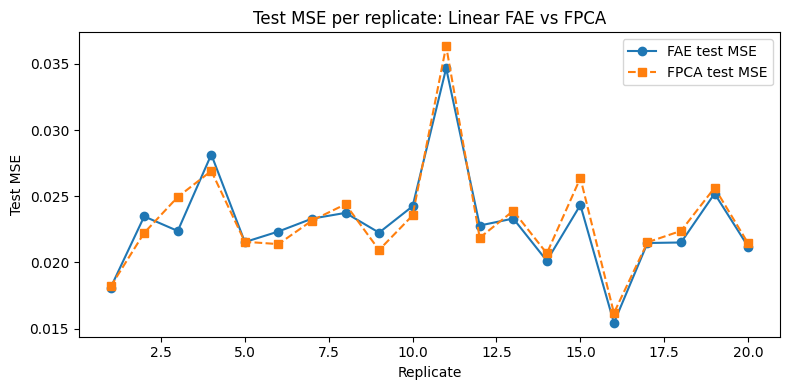

In [6]:
import matplotlib.pyplot as plt

rep_idx = np.arange(1, niter + 1)

plt.figure(figsize=(8, 4))
plt.plot(rep_idx, FAE_pred_test_acc_mean_niter, marker='o', label='FAE test MSE')
plt.plot(rep_idx, FPCA_pred_test_acc_mean_niter, marker='s', linestyle='--', label='FPCA test MSE')
plt.xlabel('Replicate')
plt.ylabel('Test MSE')
plt.title('Test MSE per replicate: Linear FAE vs FPCA')
plt.legend()
plt.tight_layout()
plt.show()


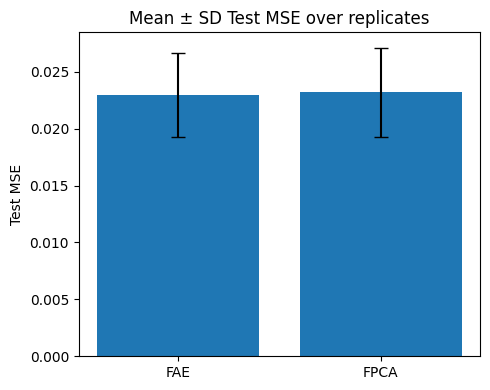

In [7]:
methods = ['FAE', 'FPCA']
means = [FAE_test_mse_mean, FPCA_test_mse_mean]
sds   = [FAE_test_mse_sd,   FPCA_test_mse_sd]

x = np.arange(len(methods))

plt.figure(figsize=(5, 4))
plt.bar(x, means, yerr=sds, capsize=5)
plt.xticks(x, methods)
plt.ylabel('Test MSE')
plt.title('Mean ± SD Test MSE over replicates')
plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_2452\3853964099.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


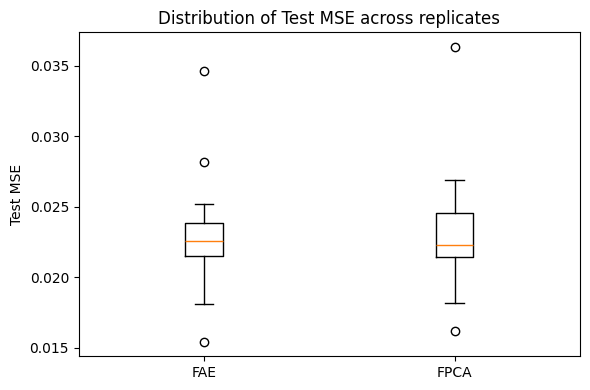

In [8]:
plt.figure(figsize=(6, 4))
plt.boxplot(
    [FAE_pred_test_acc_mean_niter, FPCA_pred_test_acc_mean_niter],
    labels=['FAE', 'FPCA']
)
plt.ylabel('Test MSE')
plt.title('Distribution of Test MSE across replicates')
plt.tight_layout()
plt.show()
